In [1]:
import torch
import warnings
import numpy as np
import math
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=UserWarning)

from torch import nn
from torch import optim
from rdkit import Chem
from torch.utils.data import Dataset
from sklearn.decomposition import PCA
from chainer_chemistry import datasets
from chainer_chemistry.dataset.preprocessors.ggnn_preprocessor import GGNNPreprocessor

In [2]:
# -- load data
class MolecularDataset(Dataset):
    def __init__(self, N, train=True):
        if train:
            start, end = 0, 100000
        else:
            start, end = 100000, 130000


        dataset, dataset_smiles = datasets.get_qm9(GGNNPreprocessor(kekulize=True),
                                                   return_smiles=True,
                                                   target_index=np.random.choice(range(133000)[start:end], N, False))

        self.atom_types = [6, 8, 7, 9, 1]
        self.V = 9

        self.adjs = torch.stack(list(map(self.adj, dataset)))
        self.sigs = torch.stack(list(map(self.sig, dataset)))
        self.prop = torch.stack(list(map(self.target, dataset)))[:, 5]
        self.prop_2 = torch.stack(list(map(self.target_2, dataset_smiles)))

    def target_2(self, smiles):
        """
            compute the number of hydrogen-bond acceptor atoms
        :param smiles: smiles molecular representation
        :return:
        """
        mol = Chem.MolFromSmiles(smiles)

        return torch.tensor(Chem.rdMolDescriptors.CalcNumHBA(mol))

    def adj(self, x):
        x = x[1]
        adjacency = np.zeros((self.V, self.V)).astype(float)
        adjacency[:len(x[0]), :len(x[0])] = x[0] + 2 * x[1] + 3 * x[2]
        return torch.tensor(adjacency)

    def sig(self, x):
        x = x[0]
        atoms = np.ones((self.V)).astype(float)
        atoms[:len(x)] = x
        out = np.array([int(atom == atom_type) for atom_type in self.atom_types for atom in atoms]).astype(float)
        return torch.tensor(out).reshape(5, len(atoms)).T

    def target(self, x):
        """
            return Highest Occupied Molecular Orbital (HOMO) energy
        :param x:
        :return:
        """
        x = x[2]
        return torch.tensor(x)

    def __len__(self):
        return len(self.adjs)

    def __getitem__(self, item):
        return self.adjs[item], self.sigs[item], self.prop[item], self.prop_2[item]


In [3]:
class kernel:
    def __init__(self, K, R, d, J, lamb_max):
        # -- filter properties
        self.R = float(R)
        self.J = J
        self.K = K
        self.d = d
        self.lamb_max = torch.tensor(lamb_max)

        # -- Half-Cosine kernel
        self.a = torch.div(torch.mul(self.R, torch.log(self.lamb_max)), self.J-self.R+1)
        
        #self.g_hat = lambda lamb: torch.sum(torch.tensor(self.d)*(torch.cos(2*math.pi*torch.tensor([_ for _ in range(self.K+1)])*(lamb/self.a+0.5)))).unsqueeze(-1).unsqueeze(-1) if 0<=-lamb<self.a else torch.zeros((1,1))
        
    def g_hat(self, lamb):
        res = torch.tensor(0.)
        for k in range(self.K+1):
            if (0<=-lamb<self.a):
                res += self.d[k]*torch.cos(2*torch.pi*k*(lamb/self.a + 0.5))
                
        return res
    
    def wavelet(self, lamb, j):
        """
            constructs wavelets ($j\in [2, J]$).
        :param lamb: eigenvalue (analogue of frequency).
        :param j: filter index in the filter bank.
        :return: filter response to input eigenvalues.
        """
        return self.g_hat(torch.log(lamb) - torch.div(self.a*(j-1), self.R))

    def scaling(self, lamb):
        """
            constructs scaling function (j=1).
        :param lamb: eigenvalue (analogue of frequency).
        :return: filter response to input eigenvalues.
        """
        res = torch.tensor(0.)
        for k in range(self.K+1):
            res += self.R/2*self.d[k]**2
            
        res += self.R/2*self.d[0]**2
        
        for j in range(2, self.J+1):
            res -= self.wavelet(lamb, j)**2
        return torch.sqrt(res)


class scattering(nn.Module):
    def __init__(self, J, L, V, d_f, K, d, R, lamb_max):
        super(scattering, self).__init__()

        # -- graph parameters
        self.n_node = V
        self.n_atom_features = d_f

        # -- filter parameters
        self.K = K
        self.d = d
        self.J = J
        self.R = R
        self.lamb_max = lamb_max
        self.filters = kernel(K=1, R=3, d=[0.5, 0.5], J=8, lamb_max=2)

        # -- scattering parameters
        self.L = L

    def compute_spectrum(self, W):
        """
            Computes eigenvalues of normalized graph Laplacian.
        :param W: tensor of graph adjacency matrices.
        :return: eigenvalues of normalized graph Laplacian
        """

        # -- computing Laplacian
        #degree = torch.sum(W, 0)
        #D = torch.diag(degree)
        
        # L = D-A
        #L = torch.sub(D, W)
        L = torch.diag_embed(W.sum(1))
        
        # -- normalize Laplacian
        diag = W.sum(1)
        dhalf = torch.diag_embed(1. / torch.sqrt(torch.max(torch.ones(diag.size()), diag)))
        L = dhalf@L@dhalf

        # -- eig decomposition
        E, V = torch.symeig(L, eigenvectors=True)
        
        # return abs(E), V
        return abs(E), V
        
    def filtering_matrices(self, W):
        """
            Compute filtering matrices (frames) for spectral filters
        :return: a collection of filtering matrices of each wavelet kernel and the scaling function in the filter-bank.
        """

        filter_matrices = []
        E, V = self.compute_spectrum(W)

        # -- scaling frame
        #filter_matrices.append(V @ ... @ V.T)
        scale_E = torch.diag_embed(torch.stack(list(map(self.filters.scaling, E)))).double()
        #E_wavelet = torch.diag_embed(torch.stack(list(map(self.filters.wavelet, E,[j]*len(E))))).double()
        filter_matrices.append(V@scale_E@(V.T))
        
        # -- wavelet frame
        for j in range(2, self.J+1):
            wavelet_stack = torch.diag_embed(torch.stack(list(map(self.filters.wavelet, E, [j]*len(E))))).double()
            filter_matrices.append(V@wavelet_stack@V.T)
        
        return torch.stack(filter_matrices)

    def forward(self, W, f):
        """
            Perform wavelet scattering transform
        :param W: tensor of graph adjacency matrices.
        :param f: tensor of graph signal vectors.
        :return: wavelet scattering coefficients
        """

        # -- filtering matrices
        g = self.filtering_matrices(W)

        # --
        U_ = [f]

        # -- zero-th layer
        # S = ...  # S_(0,1)
        # S_(0,1)
        # f [9,5] -> [1,5]
        S = f.mean(0)

        for l in range(self.L):
            U = U_.copy()
            U_ = []

            for f_ in U:
                for g_j in g:

                    U_.append(abs(g_j@f_))
                    
                    # append scattering features S_(1,i)
                    S = torch.cat((S, U_[-1].mean(0)))
            U = abs(g[0]@f)
            

        return S

In [4]:
# -- initialize scattering function
scat = scattering(L=2, V=9, d_f=5, K=1, R=3, d=[0.5, 0.5], J=8, lamb_max=2)

# -- load data
data = MolecularDataset(N=6000)

# -- Compute scattering feature maps

# -- PCA projection

# -- plot feature space

100%|██████████████████████████████████████| 6000/6000 [00:12<00:00, 473.70it/s]


In [5]:
scatter_map = torch.stack(list(map(scat.forward, data.adjs, data.sigs)))


In [6]:
scatter_map=scatter_map.float()

In [7]:
scatter_pca = scatter_map.numpy()

pca = PCA(n_components = 2)
pca.fit(scatter_pca)

scatter_trans = pca.transform(scatter_pca)


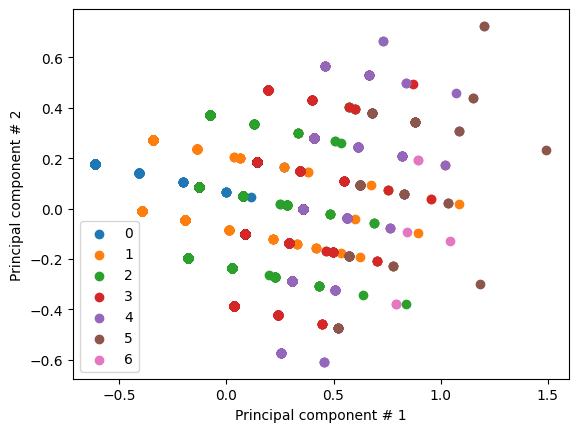

In [8]:
for i in range(max(data.prop_2)+1):
    plt.scatter(scatter_trans[data.prop_2 == i, 0], scatter_trans[data.prop_2==i, 1], label=str(i))
plt.xlabel("Principal component # 1")
plt.ylabel("Principal component # 2")
plt.legend()
plt.show()

In [9]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.n1 = nn.Linear(input_dim, hidden_dim)
        self.n2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.n1(x)
        x = torch.relu(x)
        x = self.n2(x)
        return x 

In [10]:
model = NeuralNet(365, 20, 1)



In [20]:

MyLoss = nn.MSELoss()
MyOptimizer = optim.SGD(model.parameters(), lr=0.01)

loss_epoch = []
batch_size = 5000

for epoch in range(100):
    
    # shuffle 
    idx_set = torch.randperm(5000)
    x = scatter_map[idx_set]
    y = data.prop[idx_set]
    
    loss_accum = 0 
    
    for i in range(0, 5000, batch_size):
        
        MyOptimizer.zero_grad()
        pred = model(x[i:(i+batch_size)])
        
        labels = y[i:(i+batch_size)]
        
        loss = MyLoss(pred, labels)
        
        loss.backward()
        MyOptimizer.step()
        
        loss_accum += loss.item()
        
    loss_epoch.append(loss_accum/(5000/batch_size))
    
    


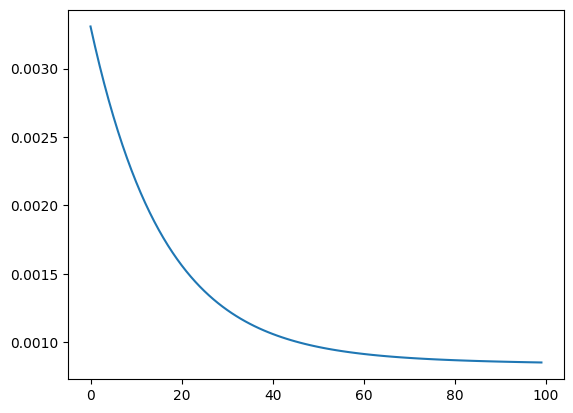

In [22]:
plt.plot(range(100), loss_epoch)

In [23]:
pred = model(scatter_map[5000:])
labels = data.prop[5000:]


print(MyLoss(pred, labels))

pred = pred.detach().numpy()
labels = labels.detach().numpy()




tensor(0.0008, grad_fn=<MseLossBackward0>)


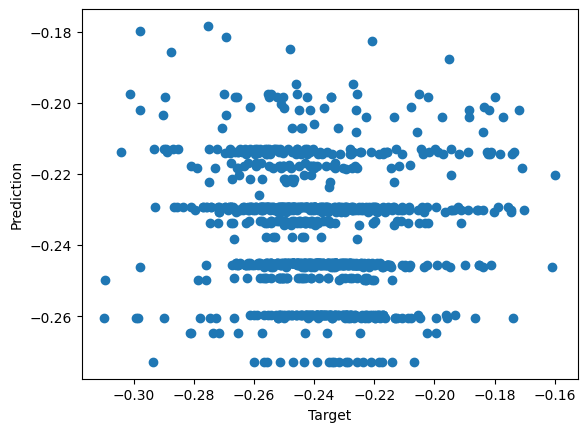

In [24]:

plt.scatter(labels, pred)
plt.xlabel("Target")
plt.ylabel("Prediction")
plt.show()